# Telecom - task

Telecom operator wants to learn to predict client outflow. If it's likely, that a client will leave, special offers will be made for them. An operator's team has collected personal data about some clients, including information about their contracts and phone plans.

### Services description

Operator offers 2 main types of services:
1. Landline phone services. Phone can be connected to several landlines simultaneously.
2. Internet. There to options - DSL or Fiber optic.

There are also secondary services available:
- Internet-security: antivirus (*DeviceProtection*) and web-filtering (*OnlineSecurity*);
- Dedicated tech support line;
- Cloud storage for online backup;
- TV Streaming and Movie Streaming;

Client can pay monthly or yearly. Multiple payment methods are available.

### Data description

Data consists of files from different sources:

- `contract.csv` — information about contracts;
- `personal.csv` — clients' personal data;
- `internet.csv` — information about internet services;
- `phone.csv` — information about phone services.

Colummn `customerID` holds unique cutomer identification code in every file

Data is relevant as of 01.02.2020

# Imports + constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import pprint
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

SEED = 261222
CUR_DATE = dt(2020,2,1)

# Data preparation

## Data loading

In [2]:
try:
    path = 'final_provider/final_provider/'
    contract_df = pd.read_csv(path + 'contract.csv')
    personal_df = pd.read_csv(path + 'personal.csv')
    internet_df = pd.read_csv(path + 'internet.csv')
    phone_df = pd.read_csv(path + 'phone.csv')
except:
    path = '/datasets/final_provider/'
    contract_df = pd.read_csv(path + 'contract.csv')
    personal_df = pd.read_csv(path + 'personal.csv')
    internet_df = pd.read_csv(path + 'internet.csv')
    phone_df = pd.read_csv(path + 'phone.csv')

### Contract

In [3]:
display(contract_df.describe())
display(contract_df.drop('MonthlyCharges', 'columns').describe())
contract_df.info()
display(contract_df.head())

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

C:\Users\skrip\AppData\Local\Temp\ipykernel_12856\3045709437.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  display(contract_df.drop('MonthlyCharges', 'columns').describe())


customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77       5               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5174            3875             4171   

           PaymentMethod TotalCharges  
count               7043         7043  
unique                 4         6531  
top     Electronic check               
freq                2365           11

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

Let's visualize monthly charges distribution

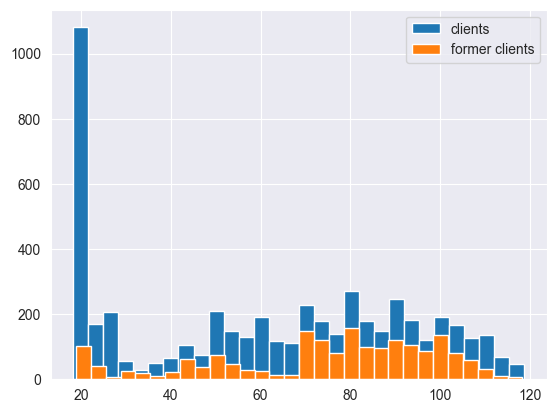

In [4]:
plt.hist(
    contract_df[contract_df['EndDate']=='No']['MonthlyCharges'],
    bins=30,
    label='clients')
plt.hist(
    contract_df[contract_df['EndDate']!='No']['MonthlyCharges'],
    bins=30,
    label='former clients')

plt.legend()
plt.show()

The vast majority of our customers prefer plans cheaper than 20. But cheap plans are significantly less popular among our former clients. So, first of all, we should pay attention to customers with monthly bills above 70.

Almost no one uses plans at 30-50 price range, and I see a gradual decline in amount of customers after 100 to 120.

There also small spikes of customers at almost every round price number.

### Personal

In [5]:
display(personal_df.describe())
display(personal_df.drop('SeniorCitizen', 'columns').describe())
personal_df.info()
display(personal_df.head())

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

C:\Users\skrip\AppData\Local\Temp\ipykernel_12856\3072237980.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  display(personal_df.drop('SeniorCitizen', 'columns').describe())


customerID gender Partner Dependents
count         7043   7043    7043       7043
unique        7043      2       2          2
top     7590-VHVEG   Male      No         No
freq             1   3555    3641       4933

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Sex division and whether the customer has a partner is approximately 50\50. About 5/7 of our customers have dependants and about 16% are seniors.

### Internet

In [6]:
display(internet_df.describe())
internet_df.info()
display(internet_df.head())

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

Most of our customers use the internet. Optional services are used by 1/2 to 2/3 of internet users. The most popular optional services are online security and tech support, while the most unpopular are connected to streaming.

### Landine

In [7]:
display(phone_df.describe())
phone_df.info()
display(phone_df.head())

customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

About 90% of customers use landline. A bit under half have multiple lines connected.

None of the datasets contained obvious gaps or duplicates. But not everyone uses internet or landline, after merging of dataframes I will check again if there are users, who don't use any services.

## Work plan

1. Date preprocessing

    a. Merge all dataframes using customerID
    
    b. Convert BeginDate and EndDate to datetime
    
    c. Add column, which shows how long a person was our customer in days
    
    d. Convert TotalCharges to numeric
    
    e. Add target column


2. Do additional research on merged dataframe


3. Extract 25% of data for test set


4. Encode data if relevant


5. Train a models using cross-validation, will try following options:

    a. LogisticRegression
    
    b. DecisionTreeClassifier
    
    c. RandomForestClassifier
    
    d. lightGBM
    
    
6. Chose a model with the best AUC-ROC score and write recommendations based on training results

# Model preparation

## Data preprocessing

Merging all dataframes into one

In [8]:
full_data = contract_df.merge(personal_df, left_on='customerID', right_on='customerID', how='outer')
full_data = full_data.merge(internet_df, left_on='customerID', right_on='customerID', how='outer')
full_data = full_data.merge(phone_df, left_on='customerID', right_on='customerID', how='outer')

In [9]:
full_data.info()
display(full_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female              0     Yes         No             DSL             No   
1    Male              0      No         No             DSL            Yes   
2    Male              0      No         No             DSL            Yes   
3    Male              0      No         No             DSL            Yes   
4  Female              0      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

In [10]:
full_data[full_data['BeginDate'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        0 non-null      object 
 1   BeginDate         0 non-null      object 
 2   EndDate           0 non-null      object 
 3   Type              0 non-null      object 
 4   PaperlessBilling  0 non-null      object 
 5   PaymentMethod     0 non-null      object 
 6   MonthlyCharges    0 non-null      float64
 7   TotalCharges      0 non-null      object 
 8   gender            0 non-null      object 
 9   SeniorCitizen     0 non-null      int64  
 10  Partner           0 non-null      object 
 11  Dependents        0 non-null      object 
 12  InternetService   0 non-null      object 
 13  OnlineSecurity    0 non-null      object 
 14  OnlineBackup      0 non-null      object 
 15  DeviceProtection  0 non-null      object 
 16  TechSupport       0 non-null      object 
 17  Streaming

There no gaps in the main table and the personal data table, however there are some in the table relating to internet and landline. Obviously not everyone is going to use all services our company can offer. In such cases I will replace gaps with "Not used".

In [11]:
full_data = full_data.fillna('Not used')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Converting BeginDate and EndDate to datetime. Replacing rows with 'No' in EndDate with NA.

In [12]:
full_data['EndDate'] = full_data['EndDate'].replace('No', '1970-01-01')

for column in ['BeginDate', 'EndDate']:
    full_data[column] = pd.to_datetime(
      full_data[column].str.strip(), format='%Y-%m-%d')


full_data['EndDate'] = full_data['EndDate'].drop(
    full_data[full_data['EndDate']==full_data['EndDate'].min()].index,
    errors='ignore')

Adding column *ContractDays*, containing amount of days, during which a client had an active contract with us.

In [13]:
full_data['ContractDays'] = (
    full_data['EndDate'] - full_data['BeginDate'])

full_data['ContractDays'] = full_data['ContractDays'].fillna(
    (CUR_DATE - full_data['BeginDate']))

full_data['ContractDays'] = full_data['ContractDays'].dt.days

Adding column *StillCustomer*, it will be used as target.

In [14]:
full_data['StillCustomer'] = full_data['EndDate'].isna()

Converting TotalCharges to numeric.

In [15]:
full_data['TotalCharges'] = full_data['TotalCharges'].replace(' ','0.0')
full_data['TotalCharges'] = full_data['TotalCharges'].astype(float)

Filling total charges if 0, based on monthly charges and number of contract days.

In [16]:
def calc_total_charges(row):
    if row['TotalCharges'] == 0.0:
        row['TotalCharges'] = row['MonthlyCharges'] * row['ContractDays']/30
    
    return row

full_data = full_data.apply(calc_total_charges, 'columns')
full_data[full_data['MonthlyCharges']==0.0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        0 non-null      object        
 1   BeginDate         0 non-null      datetime64[ns]
 2   EndDate           0 non-null      datetime64[ns]
 3   Type              0 non-null      object        
 4   PaperlessBilling  0 non-null      object        
 5   PaymentMethod     0 non-null      object        
 6   MonthlyCharges    0 non-null      float64       
 7   TotalCharges      0 non-null      float64       
 8   gender            0 non-null      object        
 9   SeniorCitizen     0 non-null      int64         
 10  Partner           0 non-null      object        
 11  Dependents        0 non-null      object        
 12  InternetService   0 non-null      object        
 13  OnlineSecurity    0 non-null      object        
 14  OnlineBackup      0 non-null      obje

In [17]:
full_data.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0           Electronic check           29.85         29.85  Female   
1               Mailed check           56.95       1889.50    Male   
2               Mailed check           53.85        108.15    Male   
3  Bank transfer (automatic)           42.30       1840.75    Male   
4           Electronic check           70.70        151.65  Female   

   SeniorCitizen  ... InternetService OnlineSecurity OnlineBackup  \
0              0  ...             DSL             No          Yes   
1              0  ...             DSL            Yes           No   
2              0  ...             DSL            Yes          Yes   
3              0  ...             DSL            Yes           No   
4              0  ...     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  \
0               No          No          No              No      Not used   
1              Yes          No          No              No            No   
2               No          No          No              No            No   
3              Yes         Yes          No              No      Not used   
4               No          No          No              No            No   

  ContractDays StillCustomer  
0           31          True  
1         1036          True  
2           61         False  
3         1371          True  
4           61         False  

[5 rows x 22 columns]

I will try to do additional research and remove data, which don't have significant impact on customers' decision.

Right away *BeginDate* and *EndDate* can be excluded, they are replaced with *ContractDays*, which shows how long a person has been our customer. I will also remove *PaperlessBilling* as more detailed information is present in *PaymentMethod*.

In [18]:
full_data = (full_data.drop('BeginDate', 'columns')
             .drop('EndDate', 'columns')
             .drop('PaperlessBilling', 'columns'))

C:\Users\skrip\AppData\Local\Temp\ipykernel_12856\1921886606.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  full_data = (full_data.drop('BeginDate', 'columns')
C:\Users\skrip\AppData\Local\Temp\ipykernel_12856\1921886606.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  full_data = (full_data.drop('BeginDate', 'columns')
C:\Users\skrip\AppData\Local\Temp\ipykernel_12856\1921886606.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  full_data = (full_data.drop('BeginDate', 'columns')


In [19]:
full_data.head()

customerID            Type              PaymentMethod  MonthlyCharges  \
0  7590-VHVEG  Month-to-month           Electronic check           29.85   
1  5575-GNVDE        One year               Mailed check           56.95   
2  3668-QPYBK  Month-to-month               Mailed check           53.85   
3  7795-CFOCW        One year  Bank transfer (automatic)           42.30   
4  9237-HQITU  Month-to-month           Electronic check           70.70   

   TotalCharges  gender  SeniorCitizen Partner Dependents InternetService  \
0         29.85  Female              0     Yes         No             DSL   
1       1889.50    Male              0      No         No             DSL   
2        108.15    Male              0      No         No             DSL   
3       1840.75    Male              0      No         No             DSL   
4        151.65  Female              0      No         No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies MultipleLines  ContractDays  StillCustomer  
0              No      Not used            31           True  
1              No            No          1036           True  
2              No            No            61          False  
3              No      Not used          1371           True  
4              No            No            61          False

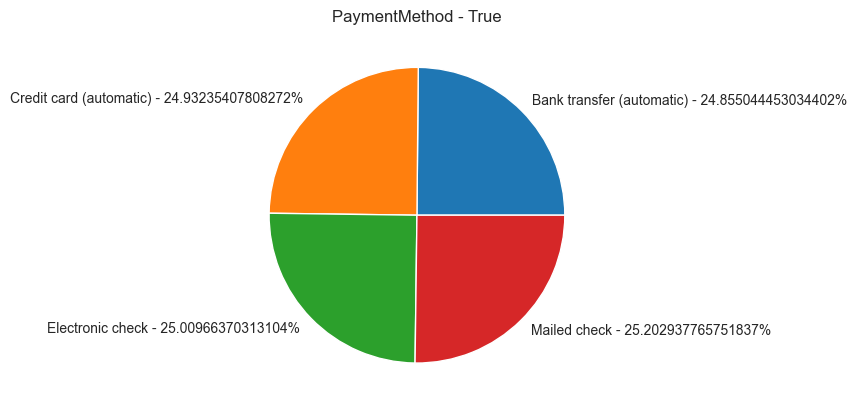

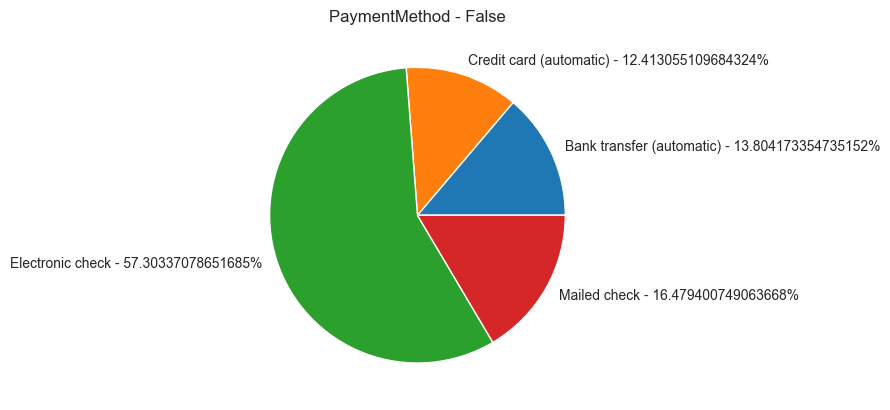

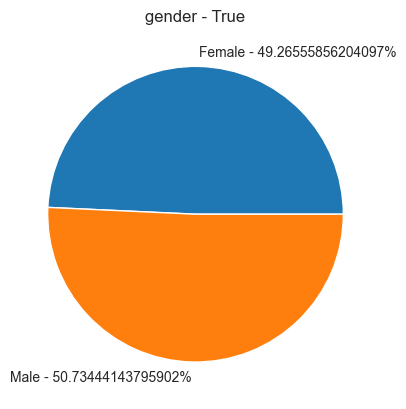

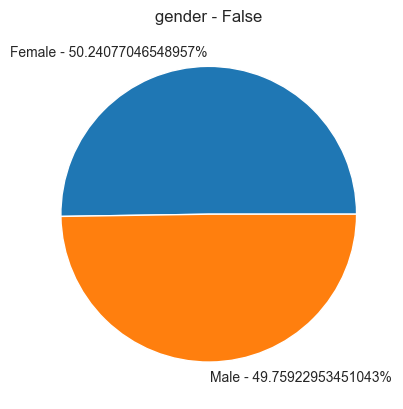

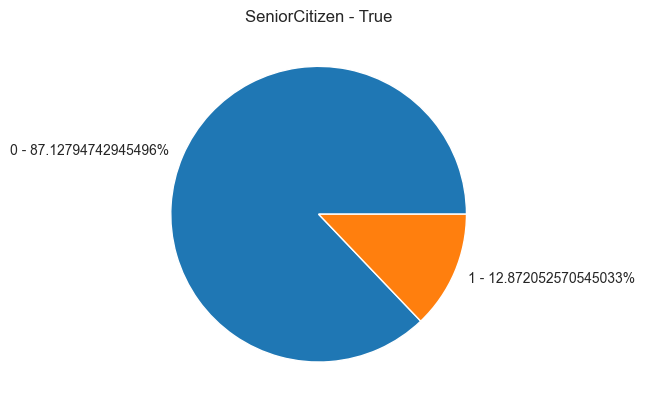

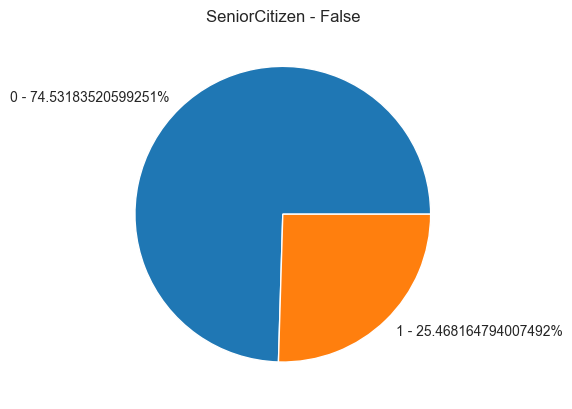

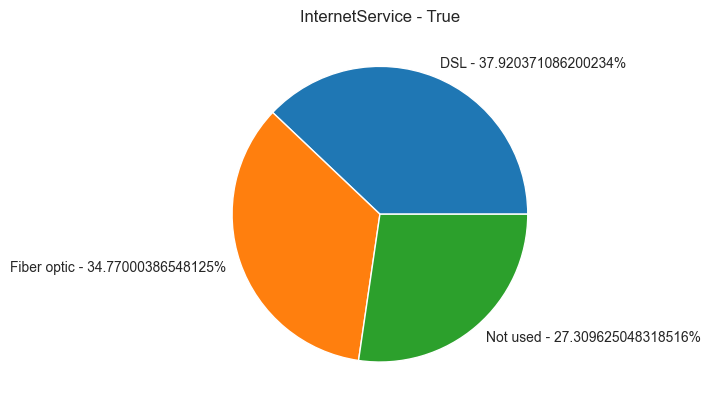

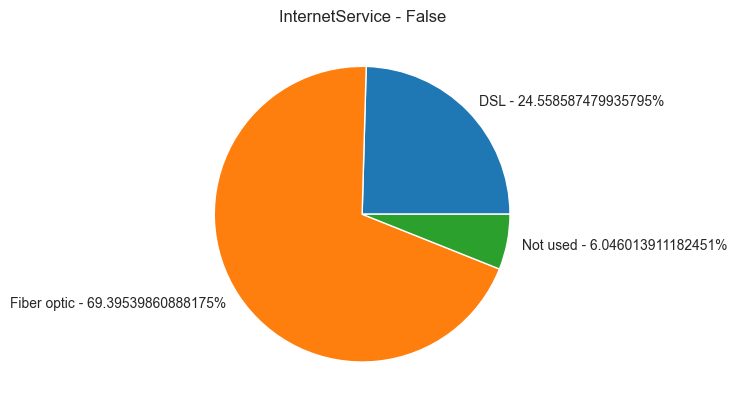

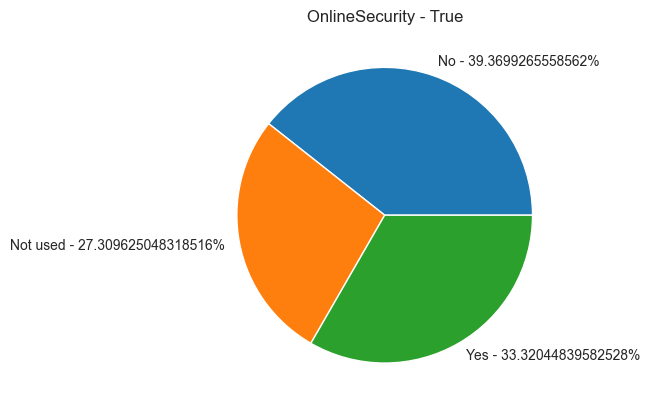

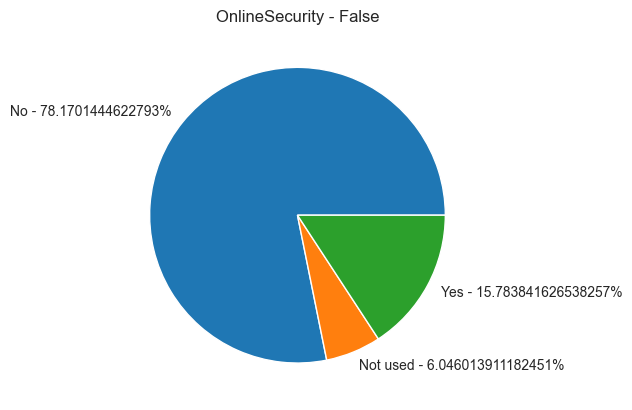

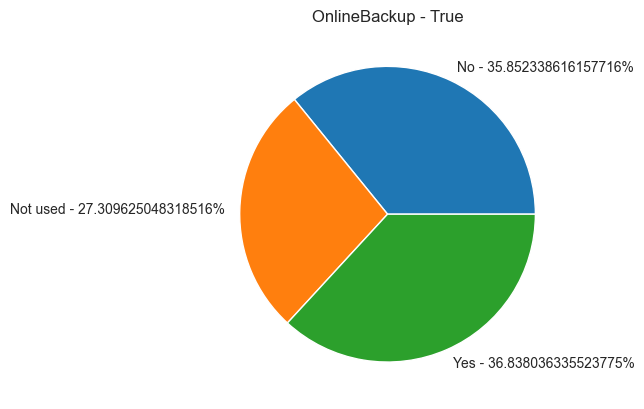

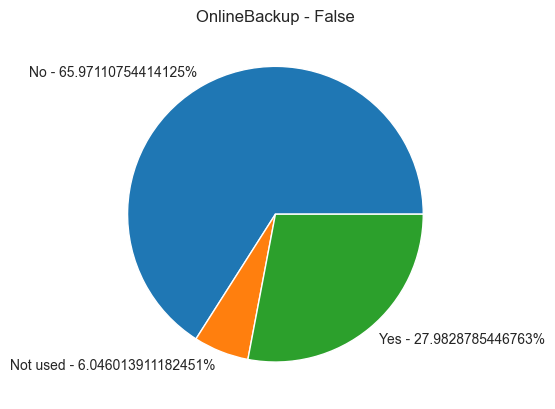

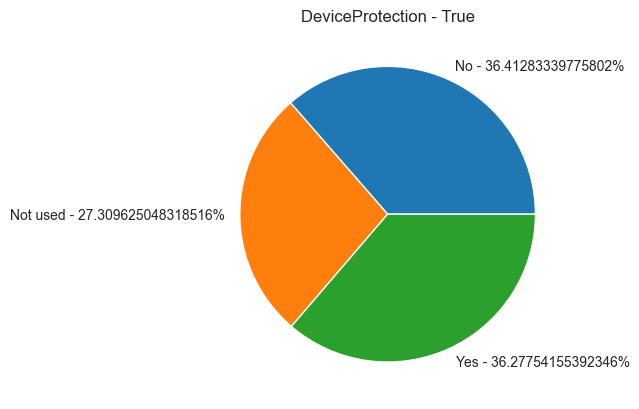

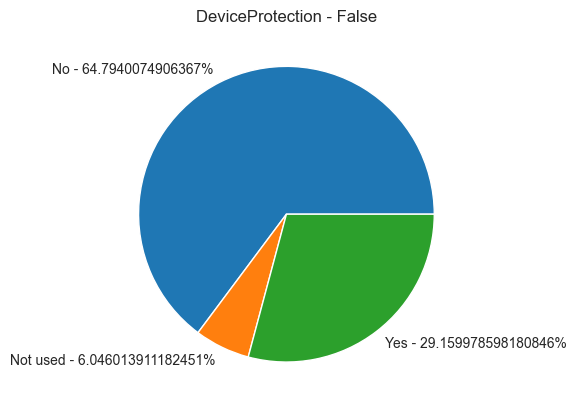

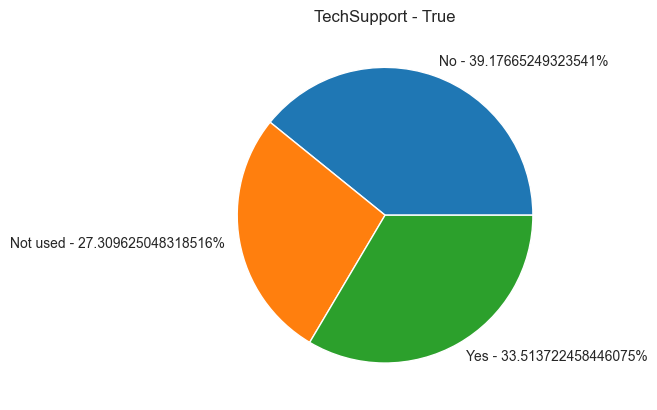

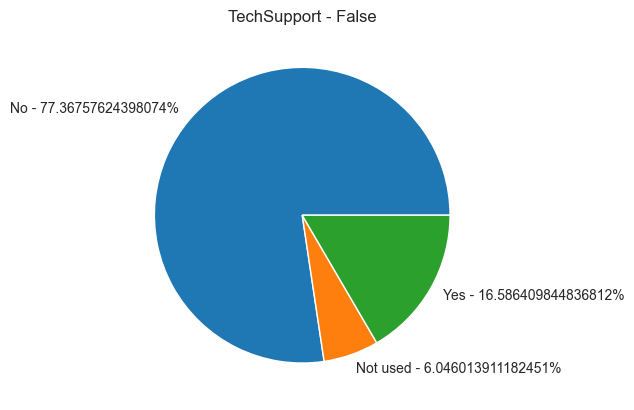

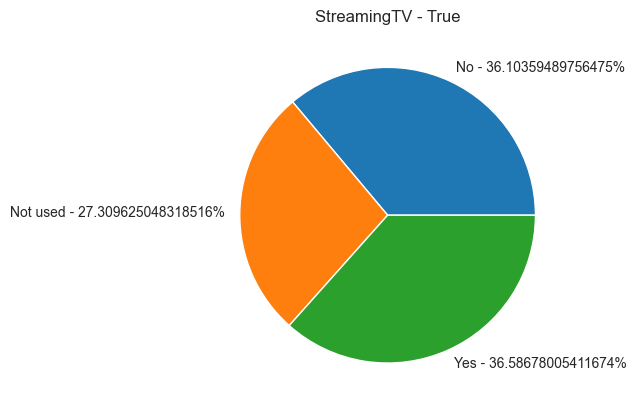

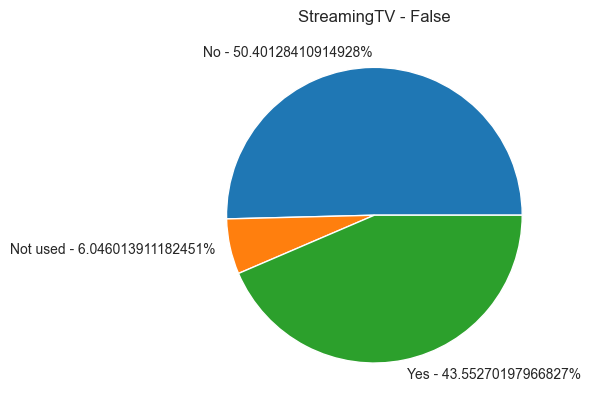

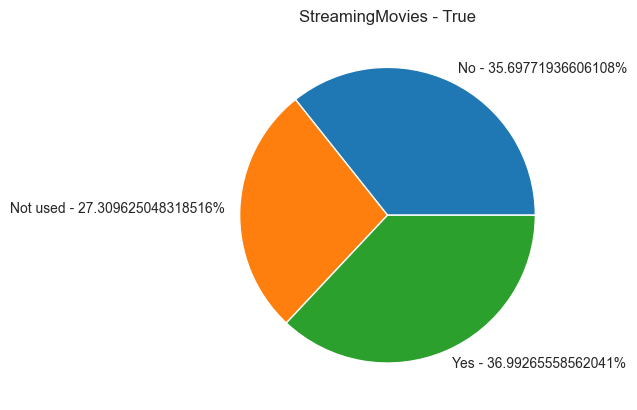

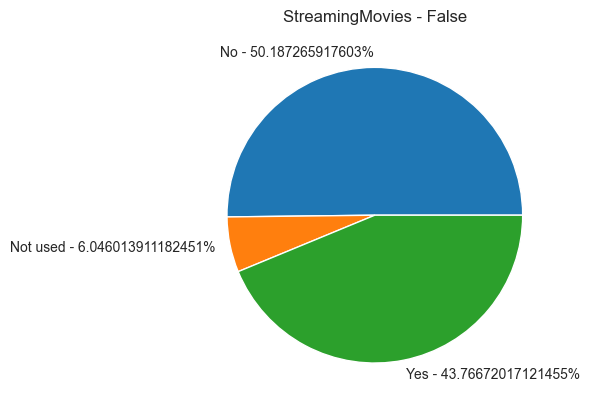

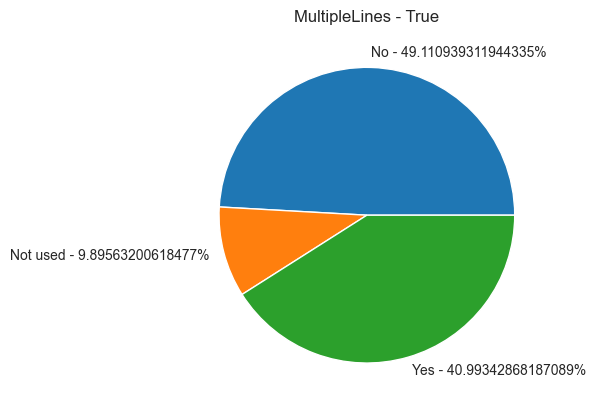

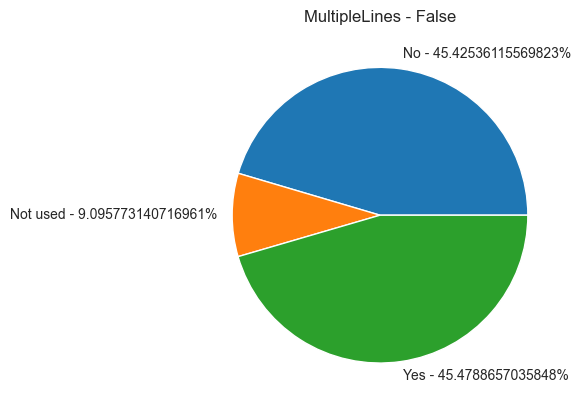

In [20]:
for criteria in [
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines']:
    for StillCustomer in [True, False]:
        grouping = full_data[full_data['StillCustomer']==StillCustomer].groupby(criteria).count()['customerID']
        values = []
        names = []
        for index in grouping.index:
            percentage = (grouping[index]/grouping.sum())*100
            values.append(percentage)
            names.append(f'{index} - {percentage}%')

        plt.pie(values, labels=names)
        plt.title(f'{criteria} - {StillCustomer}')
        plt.show()


Fields *gender*, *StreamingMovies*, *MultipleLines* vary slightly between current and former clients. *customerID* also won't help in training a model. I will remove those to speed up training.

Also it should be noticed, that customers using additional services leave rare. Probably we should look into promoting those services more to new customers.

In [ ]:
full_data = (full_data.drop('gender', 'columns')
             .drop('StreamingTV', 'columns')
             .drop('StreamingMovies', 'columns')
             .drop('MultipleLines', 'columns')
             .drop('customerID', 'columns'))

Preparing data for ML model.

In [ ]:
features = full_data.drop('StillCustomer', axis=1)
target = full_data['StillCustomer']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=SEED)

Standardizing numeric values.

In [ ]:
num_columns = []
for column in full_data.columns:
    if full_data[column].dtype =='float64' or full_data[column].dtype =='int64':
        num_columns += [column]
scaler = StandardScaler()
scaler.fit(features_train[num_columns])
features_train[num_columns] = scaler.transform(features_train[num_columns])
features_valid[num_columns] = scaler.transform(features_valid[num_columns])

# Model preparation

In [ ]:
model_stats = {}

## LogisticRegression

Encoding data with OHE

In [ ]:
features_train_lr = features_train.copy()
features_valid_lr = features_valid.copy()

In [ ]:
cat_features = features_train_lr.select_dtypes(include='object').columns.to_list()
print(cat_features)

In [ ]:
# Drop='first' removes the first feature from the encoded ones:
# thus avoiding the dummy variable trap.
# We set handle_unknown='ignore':
# any previously unseen values of the feature will be ignored (during transformation).
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# We train the encoder on the specified categorical features of the training set.
encoder_ohe.fit(features_train_lr[cat_features])

# We add the encoded features to X_train_ohe.
encoder_ohe.get_feature_names_out() # allows us to obtain the column names.
features_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[cat_features])

# We remove the non-encoded categorical features (original columns).
features_train_ohe = features_train_lr.drop(cat_features, axis=1)

# Let's see the result.
features_train_ohe.head()

In [ ]:
%%time

parameters = {
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'class_weight': ['balanced', None],
    'penalty':['l1', 'l2', 'elasticnet'], 
    'n_jobs': [-1]}

estimator = LogisticRegression(random_state=SEED)
model = GridSearchCV(
    estimator,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1)
model.fit(features_train_ohe, target_train)

print('Best score:', model.best_score_)
print(model.best_params_)
model_stats['LogisticRegression'] = model.best_score_

best_model = model.best_estimator_
# predict_valid = best_model.predict(features_valid_ohe)
# print('ROC-AUC validation:', roc_auc_score(target_valid, predict_valid))
# print('Confusion matrix:\n', confusion_matrix(target_valid, predict_valid))

## DecisionTreeClassifier

Encoding with ordinal encoding

In [ ]:
encoder = OrdinalEncoder()

features_train_ordinal = features_train.copy()
features_valid_ordinal = features_valid.copy()

features_train_ordinal[cat_features] = encoder.fit_transform(features_train_ordinal[cat_features])
features_valid_ordinal[cat_features] = encoder.transform(features_valid_ordinal[cat_features])

display(features_train_ordinal.head())

In [ ]:
%%time

parameters = {
    'max_depth': [1,2,3,4,5,10,20,40,100],
    'class_weight': ['balanced', None],
    'random_state': [SEED]
}

estimator = DecisionTreeClassifier(random_state=SEED)
model = GridSearchCV(
    estimator,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1)
model.fit(features_train_ordinal, target_train)

print('Best score:', model.best_score_)
print(model.best_params_)
model_stats['DecisionTreeClassifier'] = model.best_score_

best_model = model.best_estimator_
# predict_valid = best_model.predict(features_valid_ordinal)
# print('ROC-AUC validation:', roc_auc_score(target_valid, predict_valid))
# print('Confusion matrix:\n', confusion_matrix(target_valid, predict_valid))
# best_model.feature_importances_

In [ ]:
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame(feature_importances, features_train_ordinal.columns, ['feature'])
feature_importances_df = feature_importances_df.sort_values(by='feature')
feature_importances_df.plot(kind='barh',figsize=(10,5))

## RandomForestClassifier

Using encoded data from the previous model

In [ ]:
%%time

parameters = {
    'n_estimators': range(1, 501, 100), 
    'criterion': ['gini', 'entropy'], 
    'max_depth':range(1, 50, 2),
    'class_weight': ['balanced', None]
}

estimator = RandomForestClassifier(n_jobs=-1,random_state=SEED)
model = GridSearchCV(
    estimator,
    parameters,
    cv=5,
    scoring='roc_auc',
    verbose=1)
model.fit(features_train_ordinal, target_train)

print('Best score:', model.best_score_)
print(model.best_params_)
model_stats['RandomForestClassifier'] = model.best_score_

best_model = model.best_estimator_
# predict_valid = best_model.predict(features_valid_ordinal)
# print('ROC-AUC validation:', roc_auc_score(target_valid, predict_valid))
# print('Confusion matrix:\n', confusion_matrix(target_valid, predict_valid))
# best_model.feature_importances_

In [ ]:
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame(feature_importances, features_train.columns, ['feature'])
feature_importances_df = feature_importances_df.sort_values(by='feature')
feature_importances_df.plot(kind='barh',figsize=(10,5))

## LightGBM

No need to encode for LightGBM, model will do it itself.

In [ ]:
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    features_valid[c] = features_valid[c].astype('category')

In [ ]:
lgb_params = {
    'num_leaves': [10,31,125,200],
    'min_child_samples': [2,20,50],
    'boosting_type': ['gbdt'],
    'colsample_bytree': [.01,.5,.7],
    'max_bin': [145,255,500],
    'max_depth': [-1,40,100,200],
    'num_iterations': [100,210,500],
    'learning_rate': [0.7],
    'reg_alpha': [0.5],
    'reg_lambda': [0.002]}

In [ ]:
%%time

print(dt.now())
estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=SEED)
model = GridSearchCV(
    estimator,
    lgb_params,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=6)
model.fit(features_train, target_train)

print('Best score:', model.best_score_)
print(model.best_params_)
model_stats['LGBMClassifier'] = model.best_score_

best_model = model.best_estimator_
predict_valid = best_model.predict(features_valid)
# print('ROC-AUC validation: {0:0.4f}'.format(roc_auc_score(target_valid, predict_valid)))
# print('Training-set accuracy score: {0:0.3f}'. format(accuracy_score(target_valid, predict_valid)))

In [ ]:
cm = confusion_matrix(target_valid, predict_valid)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='')

In [ ]:
pprint.pprint(model_stats)

LGBMClassifier has the highest ROC-AUC, validating it.

In [ ]:
predict_proba_valid = best_model.predict_proba(features_valid)[:,1]
predict_valid = best_model.predict(features_valid)

print('ROC-AUC validation: {0:0.4f}'.format(roc_auc_score(target_valid, predict_proba_valid)))
print('Training-set accuracy score: {0:0.3f}'. format(accuracy_score(target_valid, predict_valid)))

In [ ]:
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame(feature_importances, features_train.columns, ['feature'])
feature_importances_df = feature_importances_df.sort_values(by='feature')
feature_importances_df.plot(kind='barh',figsize=(10,5))

# Report

1. Completed data preprocessing. In addition to planned merge and data type convertions, numerics were standardized.

2. Based on research analysis were removed columns with only very small differences between former and current customers or with their meaning being duplicated in other columns:
        BeginDate
        EndDate
        PaperlessBilling
        gender
        StreamingTV
        StreamingMovies
        MultipleLines
        customerID

3. Validation set was set aside to test the trained model.

4. Data was encoded in OHE for LogisticRegression. For DecisionTree and RandomForest data was encoded OrdinalEncoding. LGBM encoded everything itself, but string columns had to be changed to categorical.

5. After first tests the best result was shown by LGBM, which I managed to further improve to ROC-AUC 94.4% with cross-validation and 93.4% with validation set. Here are the best hyperparameters I managed to find:
        'num_leaves': [10,31,125,200],
        'min_child_samples': [2,20,50],
        'boosting_type': ['gbdt'],
        'colsample_bytree': [.01,.5,.7],
        'max_bin': [145,255,500],
        'max_depth': [-1,40,100,200],
        'num_iterations': [100,210,500],
        'learning_rate': [0.7],
        'reg_alpha': [0.5],
        'reg_lambda': [0.002]

6. Graphs of feature importance shows, that LGBM mainly uses ContractDays, MonthlyCharges and TotalCharges. This graph looks a lot more balanced for RandomForestClassifier. При больших сроках, стоило бы попробовать более точно подобрать параметры для этой модели, несмотря на менее точный изначальный результат.